In [1]:
#!pip install darts

     |████████████████████████████████| 346 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 527 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 26.4 MB 126 kB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 881.9 MB 3.8 kB/s  eta 0:00:01     |█████▍                          | 148.0 MB 28.3 MB/s eta 0:00:26     |████████▎                       | 227.9 MB 27.8 MB/s eta 0:00:24     |█████████▉                      | 271.6 MB 57.7 MB/s eta 0:00:11     |██████████████▊                 | 405.0 MB 40.1 MB/s eta 0:00:12     |████████████████████████████    | 770.0 MB 53.6 MB/s eta 0:00:03
     |████████████████████████████████| 865 kB 22.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 32.6 MB/s eta 0:00:01


     |████████████████████████████████| 952 kB 30.3 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 22.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 63 kB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 184 kB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 23.9 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 42.4 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 833 kB/s  eta 0:00:01
     |████████████████████████████████| 151 kB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import glob
import csv
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
import random
import datetime

from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if(pourcentage < 25):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [4]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/800-200'

In [5]:
os.chdir('../../Datasets/Maladies')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Maladies'

In [6]:
!ls

D-N02BA1.csv  D-N02BE1.csv  D-N05B1.csv  D-R031.csv
D-N02BA2.csv  D-N02BE2.csv  D-N05B2.csv  D-R032.csv


In [12]:
def simul():
    file_name = []
    df = []
    pourcentage = []

    my_models= []
    series_scaled_list= []
    val_scaled_list = []
    pred_series_list= []
    error_results = pd.DataFrame(columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
    i = 0
    
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files, delimiter = ';')
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        # Create a TimeSeries, specifying the time and value columns
        series = TimeSeries.from_dataframe(df_clean, 'ds', 'y')

        # Set aside the last 36 months as a validation series
        train, val = series[:-200], series[-200:]

        # Normalize the time series (note: we avoid fitting the transformer on the validation set)
        # Change name
        scaler = Scaler()
        train_scaled = scaler.fit_transform(train)
        val_scaled = scaler.transform(val)
        series_scaled = scaler.transform(series)
        print("the {} dataset has {} data points".format(file_name[i],len(series)))
        
        series_scaled_list.append(series_scaled)
        val_scaled_list.append(val_scaled)
        
        my_model = TransformerModel(
        input_chunk_length=64,
        output_chunk_length=18,
        batch_size=32,
        n_epochs=200,
        model_name=file_name[i] + "_transformer",
        nr_epochs_val_period=10,
        d_model=16,
        nhead=8,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        activation="relu",
        random_state=42,
        save_checkpoints=True,
        force_reset=True,
        )
        
        my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)
        
        my_models.append(my_model)
        
        pred_series = my_model.predict(n=200)
        
        pred_series_list.append(pred_series)
        
        df_new_row_error = pd.DataFrame(data=np.array([[file_name[i],mae(pred_series, val_scaled), mse(pred_series, val_scaled), rmse(pred_series, val_scaled)]]), columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
        error_results = pd.concat([error_results,df_new_row_error], ignore_index=True)
        i = i +1

    return file_name, my_models, series_scaled_list, val_scaled_list, pred_series_list, error_results

In [13]:
file_name, my_models, series_scaled_list, val_scaled_list, pred_series_list, error_results = simul()

D-R031
the D-R031 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-N02BE1
the D-N02BE1 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-N02BE2
the D-N02BE2 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-N02BA2
the D-N02BA2 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-R032
the D-R032 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-N05B1
the D-N05B1 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-N02BA1
the D-N02BA1 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

D-N05B2
the D-N05B2 dataset has 1000 data points


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

In [14]:
error_results.to_csv(r'../../Resultats/Resultats_200/Trasformers_results_maladies.csv', index = False)

In [15]:
print(error_results)

  DATA_SET_NAME                  MAE                   MSE  \
0        D-R031  0.17974053033738382   0.04839561915089968   
1      D-N02BE1  0.16165652886806087   0.03530454482505565   
2      D-N02BE2  0.09113281816545715  0.013690754048788048   
3      D-N02BA2  0.16004703728318334   0.03817637242940463   
4        D-R032   0.1467803715597279   0.04247524270920058   
5       D-N05B1  0.11480119448333431   0.02559906076229736   
6      D-N02BA1  0.11706644493053417    0.0203516438057434   
7       D-N05B2  0.07345580540857088  0.008677554426965961   

                  RMSE  
0  0.21999004329946317  
1  0.18789503672278213  
2  0.11700749569488293  
3  0.19538774892353059  
4  0.20609522728389557  
5  0.15999706485525714  
6   0.1426591875966753  
7  0.09315339192410527  


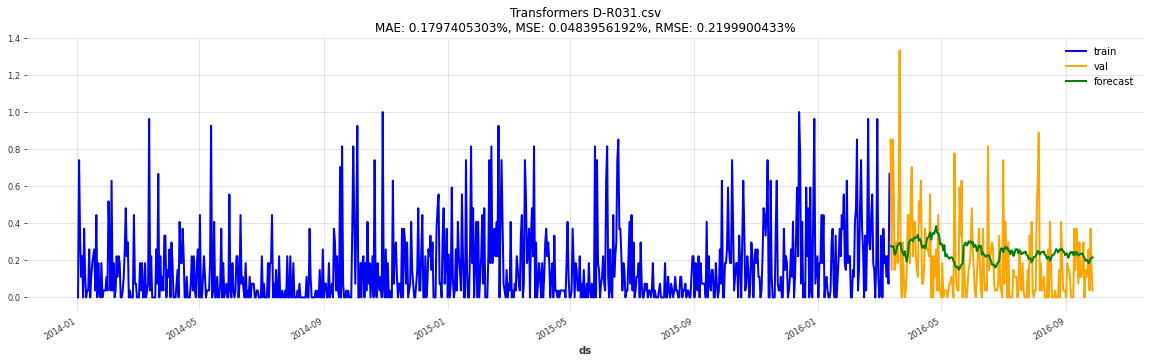

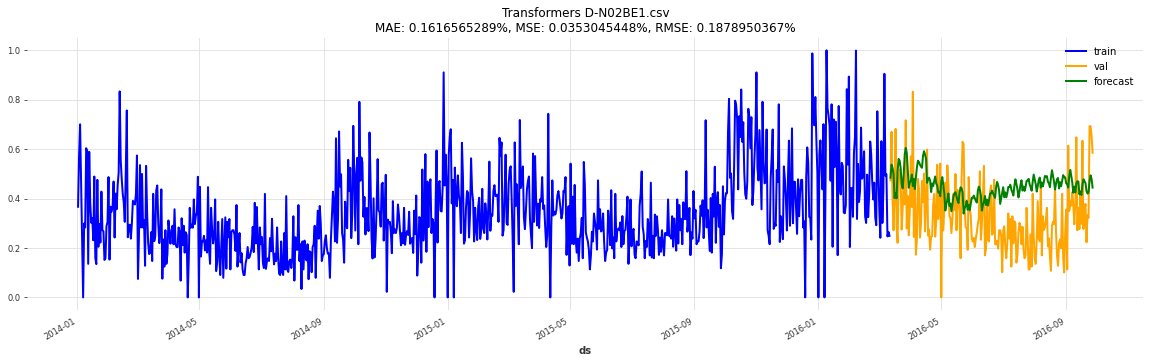

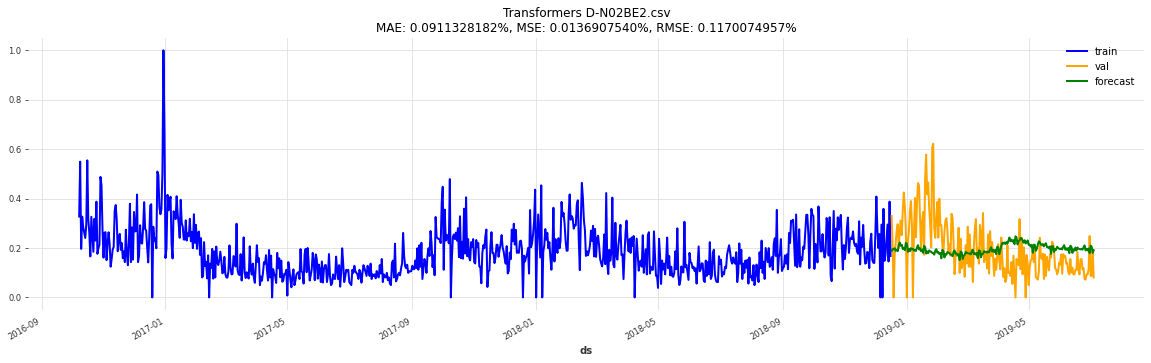

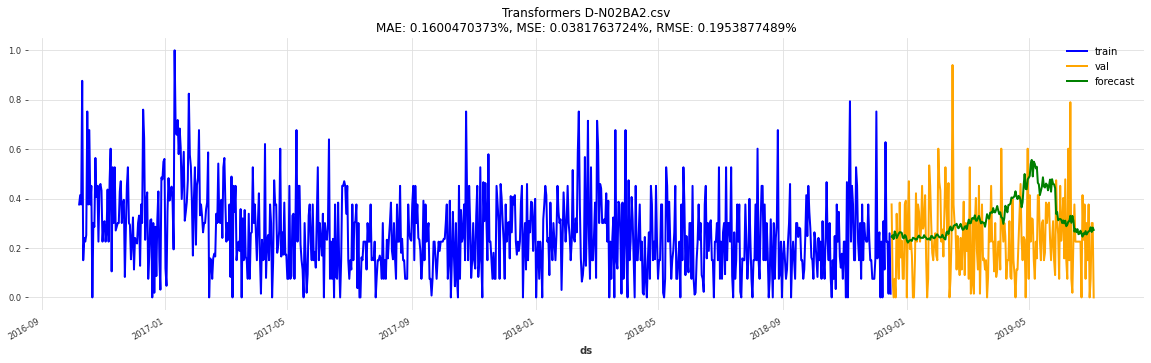

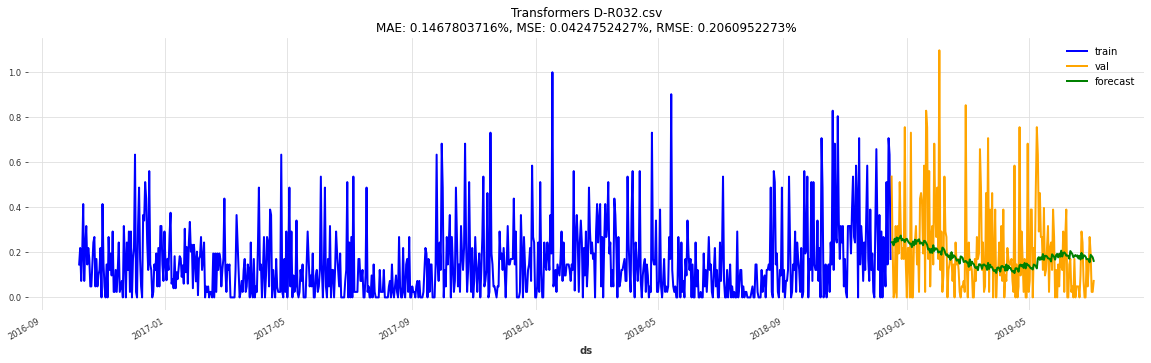

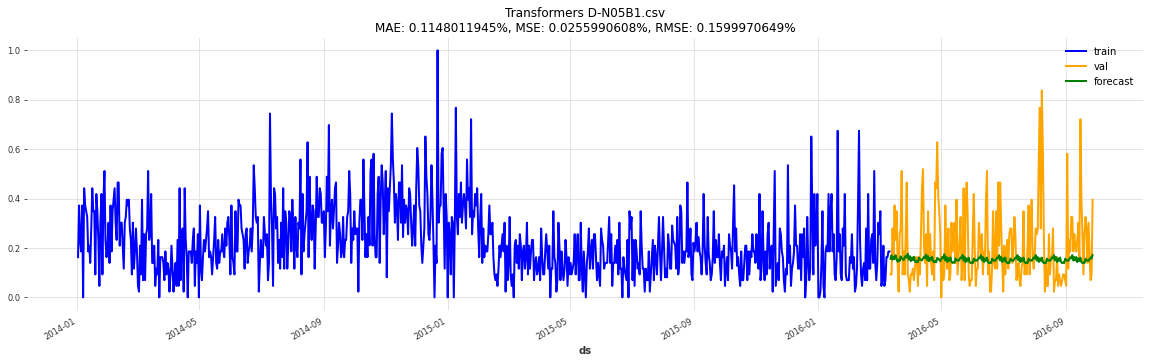

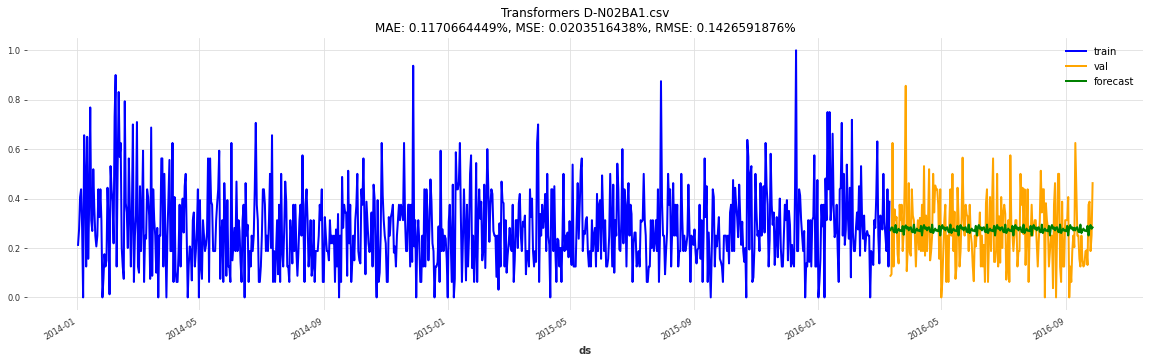

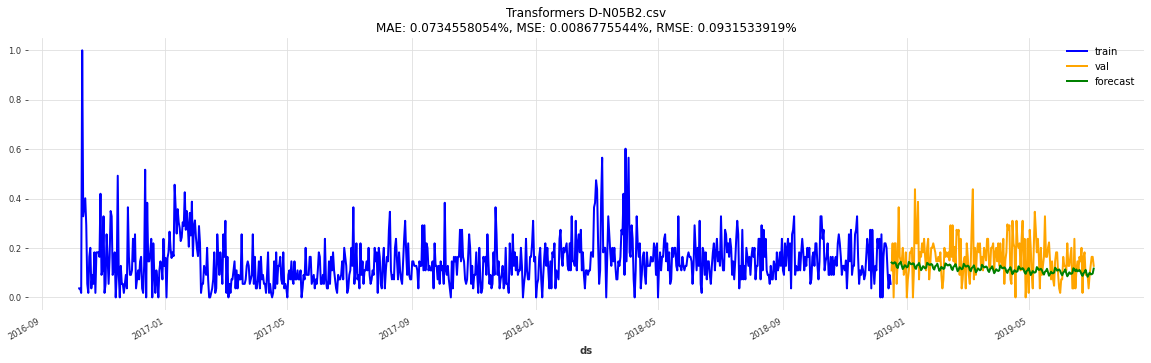

In [16]:
for i in range(len(my_models)):
    plt.figure(figsize=(20,5))
    train, val = series_scaled_list[i][:-200], series_scaled_list[i][-200:]
    train.plot(color ='blue', label="train")
    val.plot(color ='orange', label="val")
    pred_series_list[i].plot(color ='green',label="forecast")
    plt.title('Transformers {}.csv\nMAE: {:.10f}%, MSE: {:.10f}%, RMSE: {:.10f}%'.format(file_name[i],mae(pred_series_list[i], val_scaled_list[i]), mse(pred_series_list[i], val_scaled_list[i]), rmse(pred_series_list[i], val_scaled_list[i])))
    plt.legend(loc='best')
    plt.show()